In [1]:
# set width = 100%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import tarfile
import urllib
import pandas as pd
import numpy as np
from zlib import crc32
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer

In [3]:
DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml2/blob/master/"
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz?raw=true"
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path,'housing.tgz')
    urllib.request.urlretrieve(housing_url,tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path,'housing.csv')
    return pd.read_csv(csv_path)

def split_train_test(data,test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio*2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_,test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [4]:
fetch_housing_data()

In [5]:
housing = load_housing_data()
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

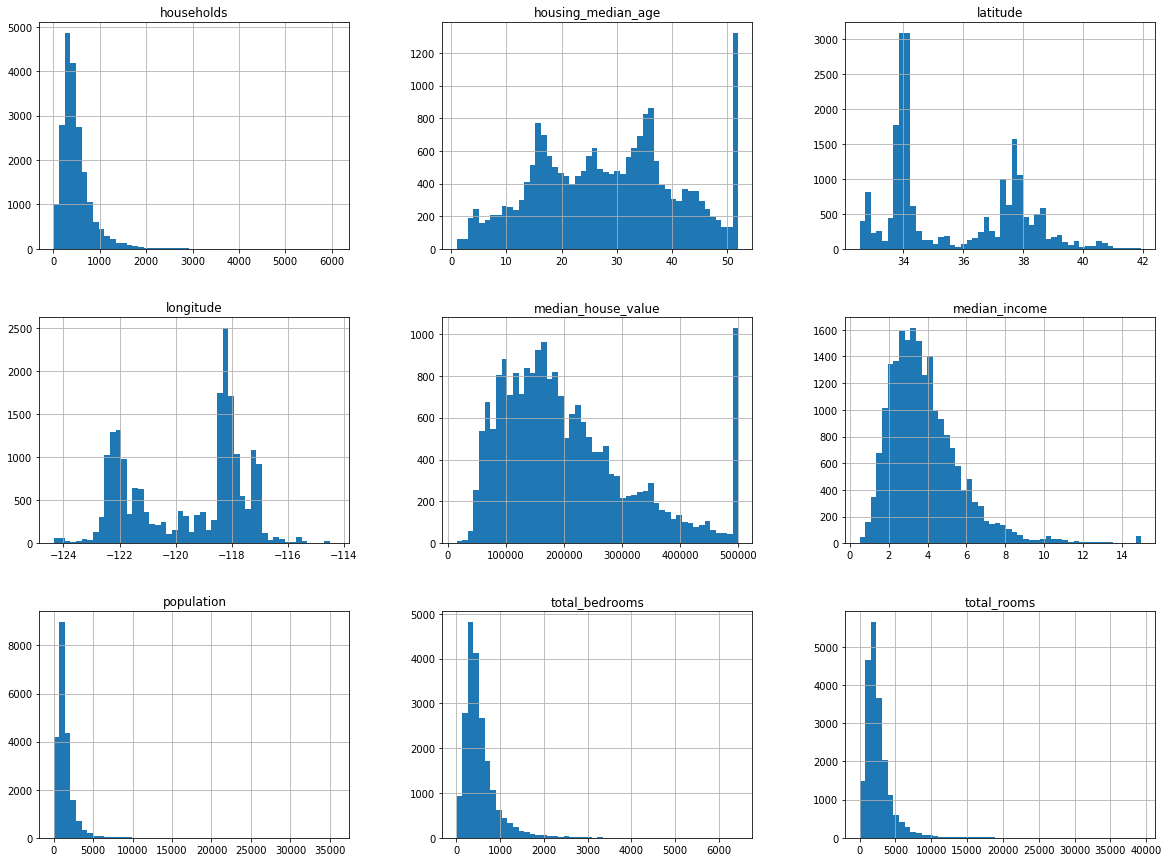

In [9]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

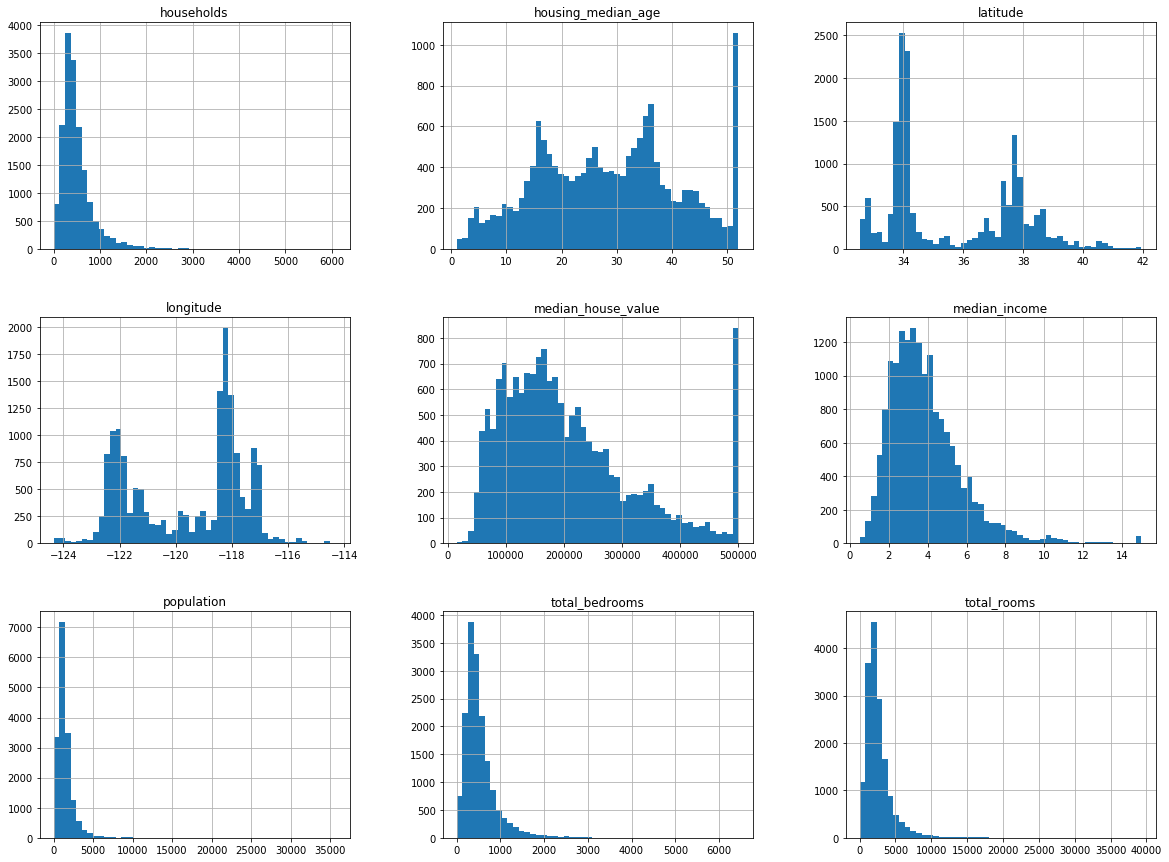

In [10]:
train_set, test_set = split_train_test(housing,0.2)
train_set.hist(bins=50, figsize=(20,15))
plt.show()

In [11]:
# must append new data and never delete for this to be stable
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
print(len(train_set), len(test_set))

16512 4128


In [12]:
# Or use something that wont change in the data set for a very long time
housing_with_id["id"] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")
print(len(train_set), len(test_set))

16322 4318


In [13]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print(len(train_set), len(test_set))

16512 4128


3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cut, dtype: float64


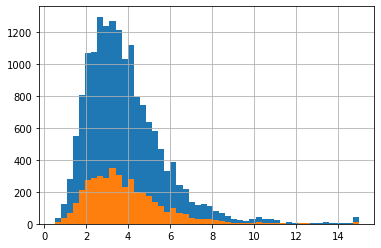

In [14]:
# make sure our split doesnt introduce bias
# bind income data to make sure outliers are not only in the test or train set
housing["income_cut"] = pd.cut(housing['median_income'],bins=[0,1.5,3.0,4.5,6,np.inf], labels = [1,2,3,4,5])
# use stratified shuffle to evenly sample our bins and split data
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing,housing["income_cut"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
print(strat_test_set['income_cut'].value_counts()/len(strat_test_set))
# drop the bin data for training
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cut", axis=1, inplace=True)
# compare datasets
strat_train_set['median_income'].hist(bins=50)
strat_test_set['median_income'].hist(bins=50)

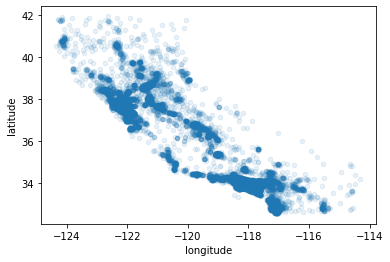

In [15]:
# data vis and exploration
housing = strat_train_set.copy()
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

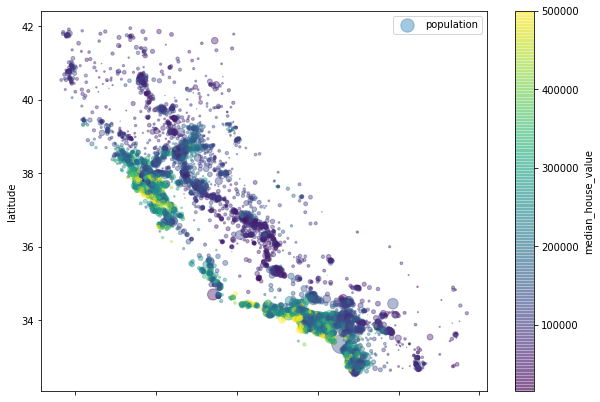

In [16]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=housing['population']/100, label='population', figsize=(10,7), c='median_house_value', cmap=plt.get_cmap("viridis"),colorbar=True)
plt.legend()

In [17]:
# look for correlations
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

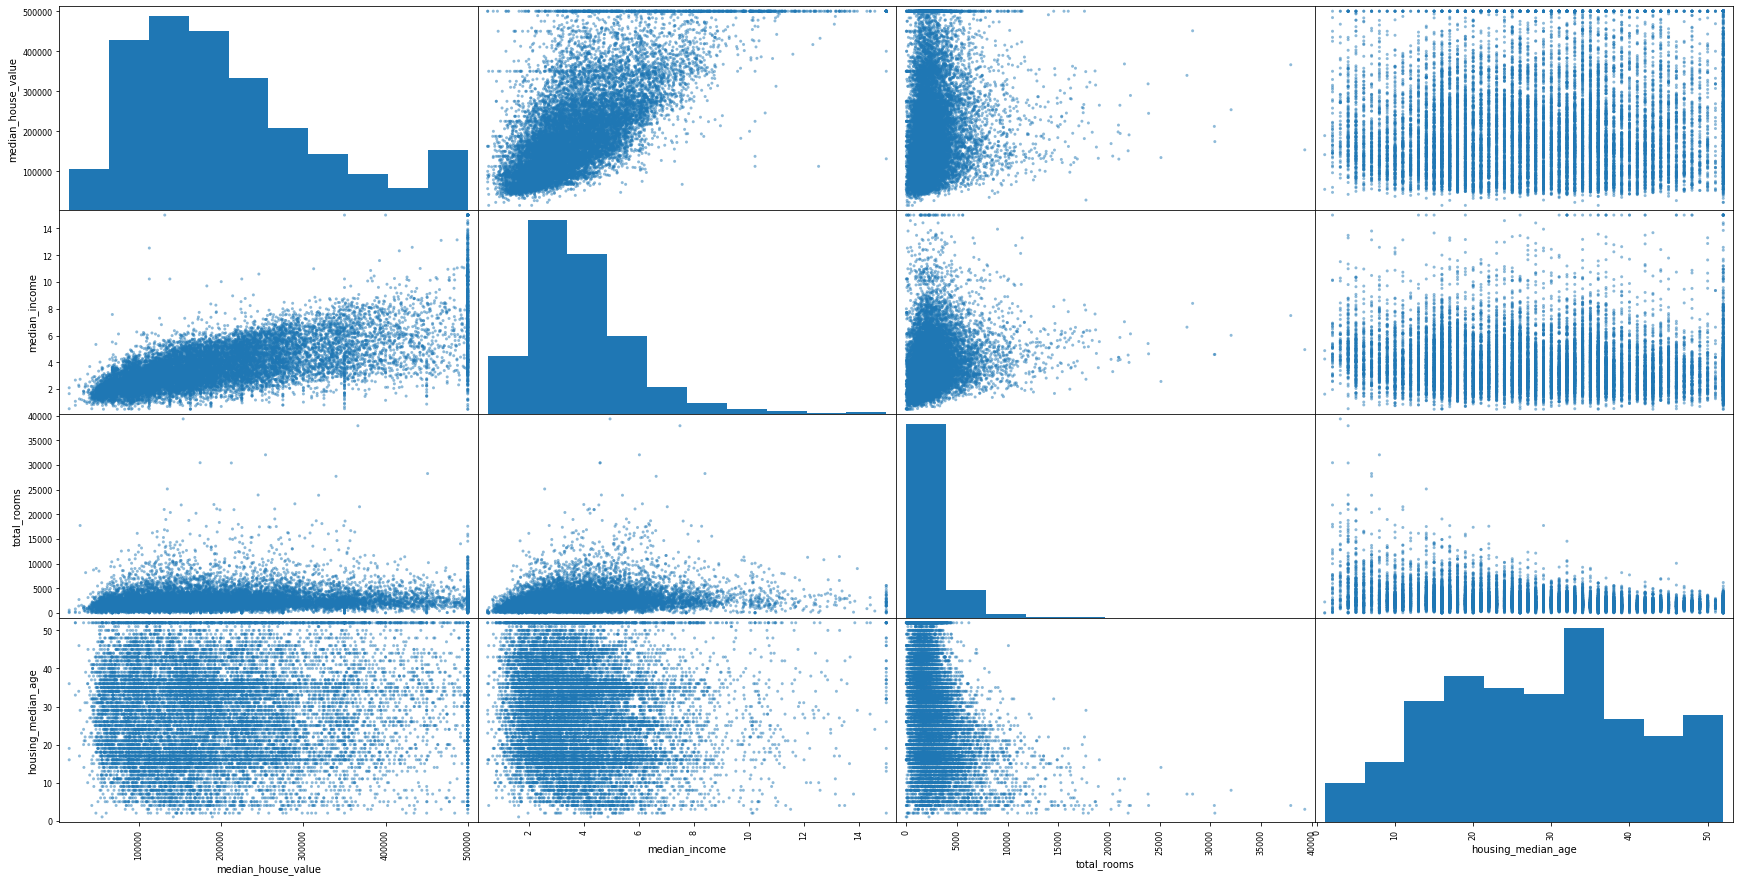

In [18]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(30,15))
plt.show()

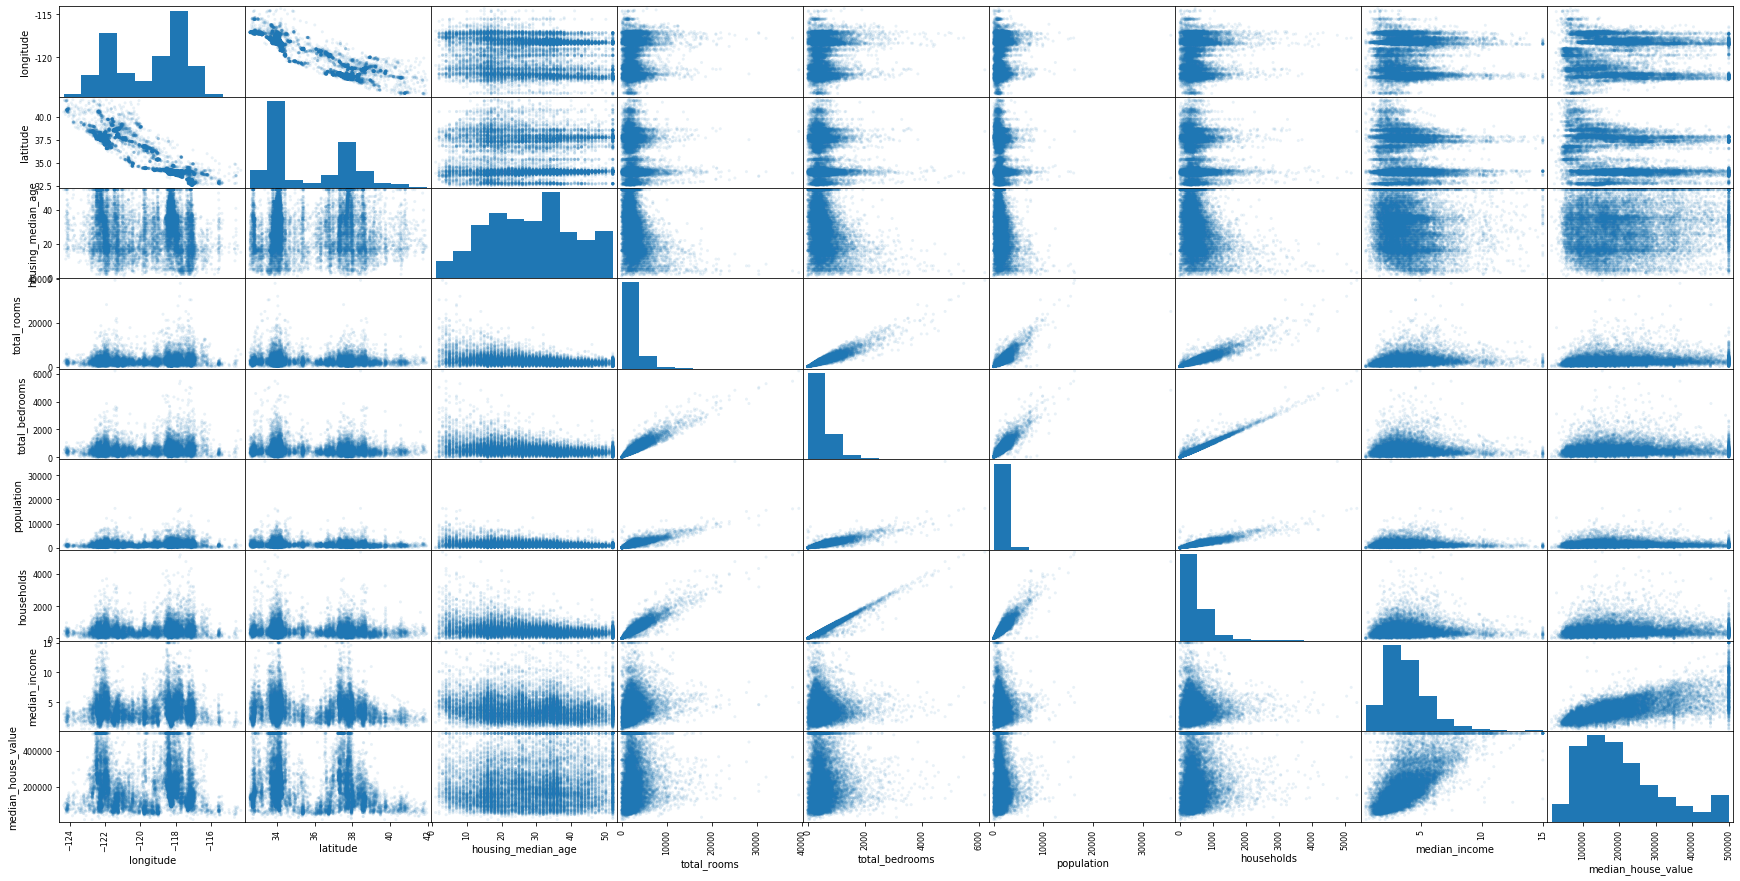

In [19]:
scatter_matrix(housing, figsize=(30,15), alpha=0.1)
plt.show()

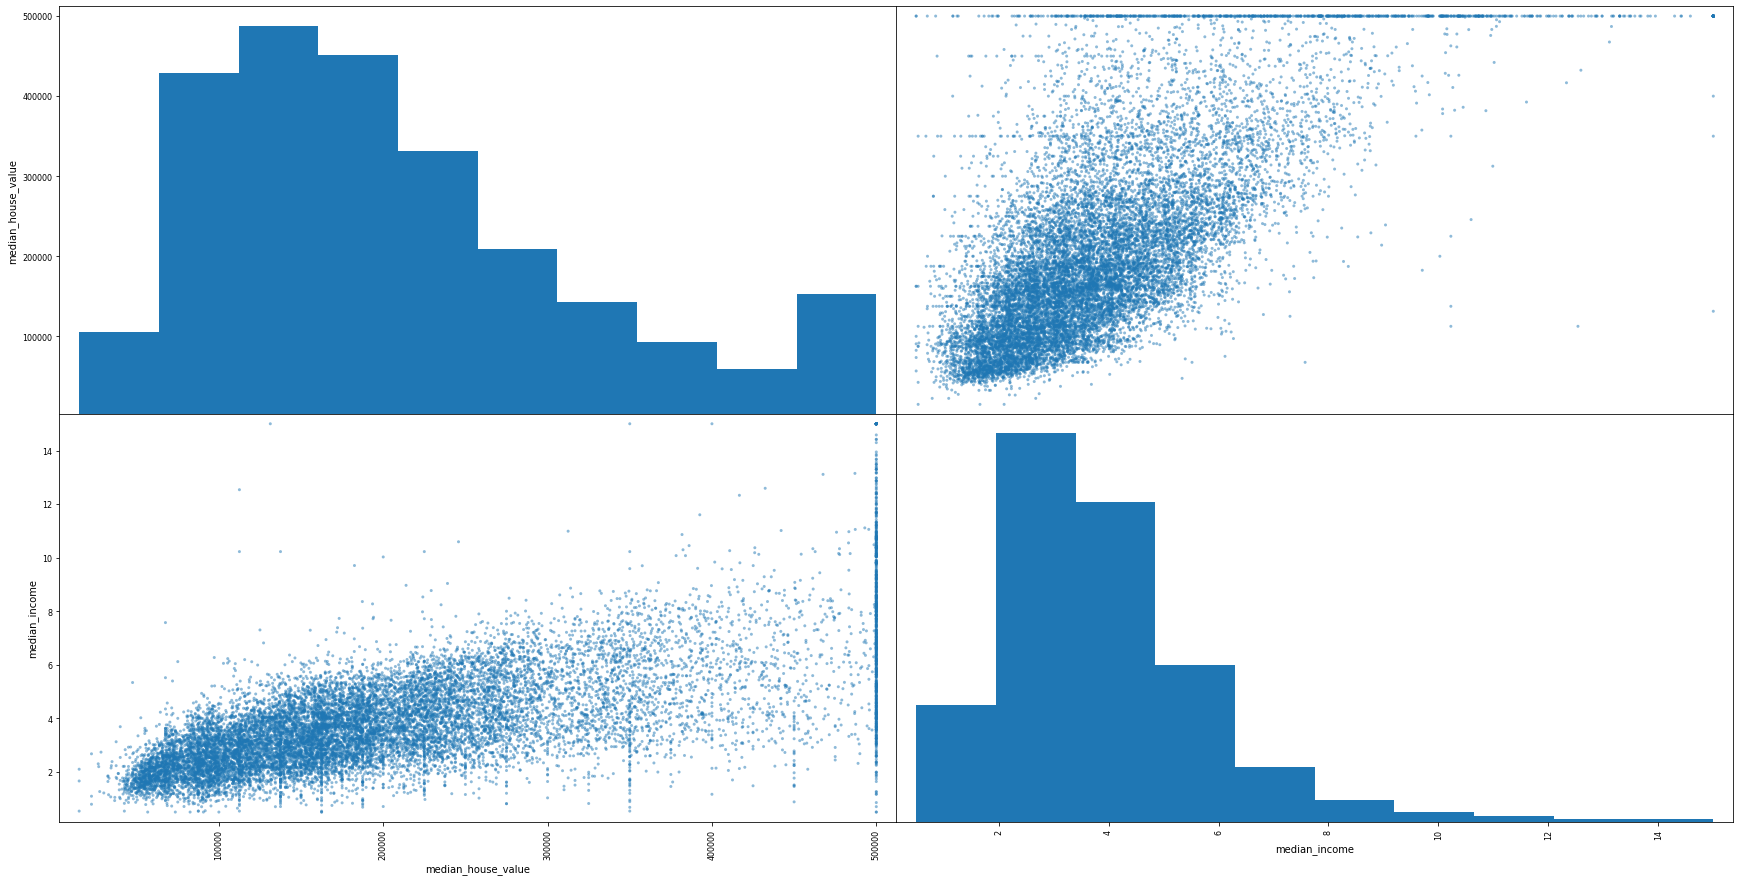

In [20]:
attributes = ['median_house_value', 'median_income']
scatter_matrix(housing[attributes], figsize=(30,15))
plt.show()

In [21]:
# combine data attributes to look for coorelations
housing["rooms_per_household"] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

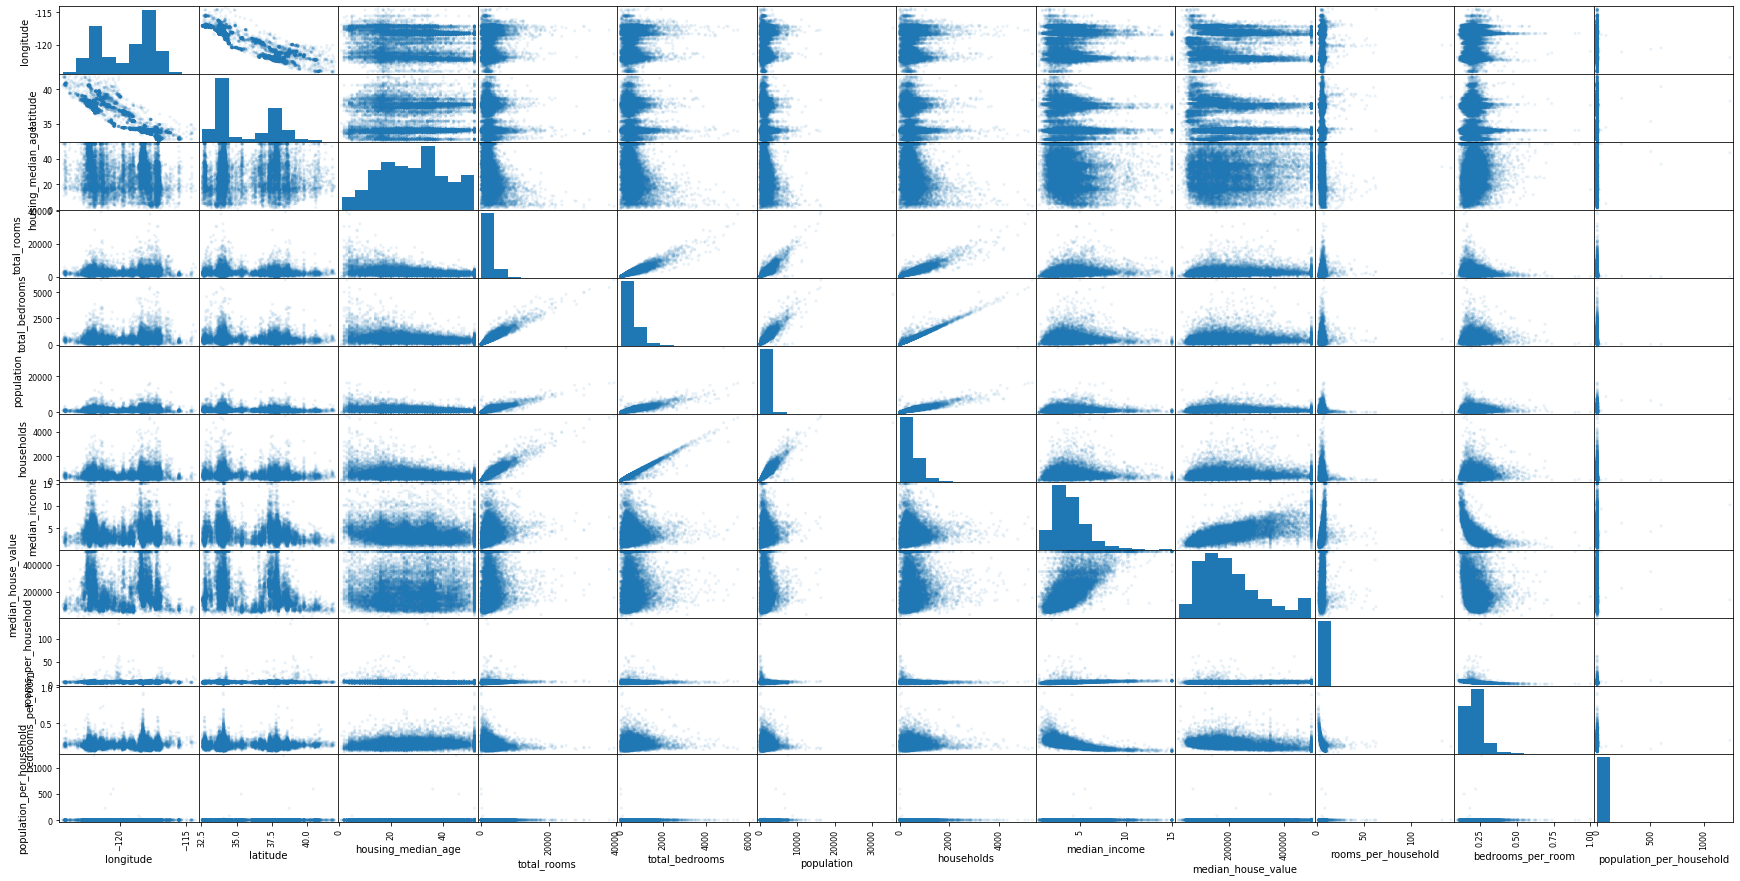

In [22]:
scatter_matrix(housing, figsize=(30,15), alpha=0.1)
plt.show()

In [23]:
housing = strat_train_set.drop("median_house_value",axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [24]:
# replace nan with median of dataset
imputer = SimpleImputer(strategy='median')
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [25]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [26]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [27]:
X = imputer.transform(housing_num)
X

array([[-121.89  ,   37.29  ,   38.    , ...,  710.    ,  339.    ,
           2.7042],
       [-121.93  ,   37.05  ,   14.    , ...,  306.    ,  113.    ,
           6.4214],
       [-117.2   ,   32.77  ,   31.    , ...,  936.    ,  462.    ,
           2.8621],
       ...,
       [-116.4   ,   34.09  ,    9.    , ..., 2098.    ,  765.    ,
           3.2723],
       [-118.01  ,   33.82  ,   31.    , ..., 1356.    ,  356.    ,
           4.0625],
       [-122.45  ,   37.77  ,   52.    , ..., 1269.    ,  639.    ,
           3.575 ]])

In [28]:
housing_tr = pd.DataFrame(X,columns=housing_num.columns,index=housing_num.index)

In [29]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

ocean_proximity
17606       <1H OCEAN
18632       <1H OCEAN
14650      NEAR OCEAN
3230           INLAND
3555        <1H OCEAN
19480          INLAND
8879        <1H OCEAN
13685          INLAND
4937        <1H OCEAN
4861        <1H OCEAN

In [30]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [31]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [32]:
from sklearn.preprocessing import OneHotEncoder 
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [33]:
# if you want a numpy array (waist of mem)
# housing_cat_1hot.toarray()

cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, populations_ix, households_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:,populations_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [35]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs

array([[-121.89, 37.29, 38.0, ..., '<1H OCEAN', 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., '<1H OCEAN', 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 'NEAR OCEAN', 4.225108225108225,
        2.0259740259740258],
       ...,
       [-116.4, 34.09, 9.0, ..., 'INLAND', 6.34640522875817,
        2.742483660130719],
       [-118.01, 33.82, 31.0, ..., '<1H OCEAN', 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 'NEAR BAY', 4.843505477308295,
        1.9859154929577465]], dtype=object)

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), # put median in for Nan
                        ('attribs_adder', CombinedAttributesAdder()), # adds rooms per house and such
                       ('std_scaler', StandardScaler()), # scales data so it is consistant across parameters
                       ])
housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [37]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
print(num_attribs)
cat_attribs = ['ocean_proximity']
 
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])
housing_prepared = full_pipeline.fit_transform(housing)

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [41]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [59]:
def train_fit_test(model, preped_data, labels):
    model.fit(preped_data,labels)
    predictions = model.predict(preped_data)
    mse = mean_squared_error(labels, predictions)
    rmse = np.sqrt(mse)
    print("RMSE:",rmse)
    return model

In [60]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared,housing_labels)

from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

68628.19819848923


In [61]:
lin_reg = train_fit_test(LinearRegression(), housing_prepared, housing_labels)

RMSE: 68628.19819848923


In [62]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = train_fit_test(DecisionTreeRegressor(), housing_prepared, housing_labels)


RMSE: 0.0


In [67]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse = np.sqrt(-scores)


In [68]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())
    
display_scores(tree_rmse)

Scores: [70222.49898256 68431.98615666 73172.97516685 69800.4817905
 71410.38712358 75622.42501025 71622.28325764 70831.17896571
 76114.09647719 69597.08653957]
Mean: 71682.53994704953
Standard Deviation: 2424.3427287739933


In [69]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_reg_rmse = np.sqrt(-scores)
display_scores(lin_reg_rmse)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard Deviation: 2731.674001798349


In [71]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = train_fit_test(RandomForestRegressor(), housing_prepared, housing_labels)
scores = cross_val_score(RandomForestRegressor(), housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_reg_rmse = np.sqrt(-scores)
display_scores(forest_reg_rmse)

RMSE: 18723.212495796164
Scores: [49656.99645346 47162.13123381 49857.96067103 52364.56316728
 49734.01092813 53559.20239425 48855.26821503 47752.40271691
 53282.29133912 50060.99529506]
Mean: 50228.58224140886
Standard Deviation: 2076.967005902942


In [73]:
import joblib

def dump_model(model, file_name):
    joblib.dump(model,file_name)
    
def load_model(file_name):
    return joblib.load(file_name)

In [75]:
dump_model(forest_reg, "forest.pkl")
os.listdir()

['Housing.ipynb', 'forest.pkl', 'datasets', '.ipynb_checkpoints']

In [78]:
from sklearn.model_selection import GridSearchCV

param_grid = [{"n_estimators":[3,10,30], 'max_features': [2,4,6,8]}, {'bootstrap':[False], 'n_estimators': [3,10], 'max_features':[2,3,4]}]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [80]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [79]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [82]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64145.36324271932 {'max_features': 2, 'n_estimators': 3}
56000.47889641827 {'max_features': 2, 'n_estimators': 10}
52945.619470279074 {'max_features': 2, 'n_estimators': 30}
59961.56718799836 {'max_features': 4, 'n_estimators': 3}
52668.531345345276 {'max_features': 4, 'n_estimators': 10}
50250.06931304971 {'max_features': 4, 'n_estimators': 30}
58852.1889202963 {'max_features': 6, 'n_estimators': 3}
52121.54013251702 {'max_features': 6, 'n_estimators': 10}
49624.59668359865 {'max_features': 6, 'n_estimators': 30}
59065.09330568492 {'max_features': 8, 'n_estimators': 3}
52178.650844711134 {'max_features': 8, 'n_estimators': 10}
49879.56378043874 {'max_features': 8, 'n_estimators': 30}
62742.165995084695 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54224.90450039633 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59629.96187419762 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53150.71419040563 {'bootstrap': False, 'max_features': 3, 'n_estimators':

In [83]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.53109022e-02, 6.53842406e-02, 4.41210958e-02, 1.80253132e-02,
       1.72060961e-02, 1.94211973e-02, 1.68795297e-02, 3.82401844e-01,
       5.55534258e-02, 1.04750658e-01, 4.94766659e-02, 1.78448873e-02,
       1.21389377e-01, 2.14194339e-05, 5.46980092e-03, 6.74354711e-03])

In [87]:
# see what is important. maybe drop things that dont work
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes),reverse=True)

[(0.3824018435721115, 'median_income'),
 (0.12138937715697552, 'INLAND'),
 (0.10475065791148849, 'pop_per_hhold'),
 (0.07531090220592122, 'longitude'),
 (0.06538424057879955, 'latitude'),
 (0.0555534257761611, 'rooms_per_hhold'),
 (0.04947666591224311, 'bedrooms_per_room'),
 (0.04412109577703137, 'housing_median_age'),
 (0.019421197333189522, 'population'),
 (0.01802531318788075, 'total_rooms'),
 (0.0178448873153931, '<1H OCEAN'),
 (0.017206096066930365, 'total_bedrooms'),
 (0.01687952973862482, 'households'),
 (0.006743547108505423, 'NEAR OCEAN'),
 (0.005469800924806952, 'NEAR BAY'),
 (2.141943393727675e-05, 'ISLAND')]

In [88]:
# train final model

final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

47850.75515575517


In [90]:
# get more states about the models preformance
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions-y_test)**2
np.sqrt(stats.t.interval(confidence,len(squared_errors)-1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([45875.67213395, 49747.48480286])